<a href="https://colab.research.google.com/github/rromerov/Machine-Learning-Projects/blob/main/Credit_Card_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve, validation_curve


import matplotlib.pyplot as plt
import seaborn as sns

Carga los datos y sustituye los nombres de las columnas del alemán al inglés de acuerdo a como se indica en la página de la UCI. 


In [74]:
file="https://raw.githubusercontent.com/rromerov/Machine-Learning-Projects/main/SouthGermanCredit.asc"
credit=pd.read_table(file,sep=" ")

In [75]:
credit.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


In [76]:
columns_name=["status","duration","credit_history","purpose","amount","savings","employment_duration","installment_rate","personal_status_sex","other_debtors","present_residence","property","age","other_installment_plans","housing","number_credits","job","people_liable","telephone","foreign_worker","credit_risk"]
credit.columns=columns_name

In [77]:
credit.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


Realiza una partición de los datos en el conjunto de entrenamiento del 85% y el de prueba de 15%. Los modelos se estarán entrenando con el método de validación cruzada, así que no es necesario en este paso generar el conjunto de validación. Define como la variable X a todas las variables de entrada y a la variable Y como la variable de salida. 


In [78]:
X=credit.iloc[:,::-1]
y=credit.iloc[:,-1]

In [79]:
X_tv,X_test,y_tv,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

 Como una primera aproximación (baseline) realizarás las siguientes transformaciones mínimas
para generar los primeros modelos. En la misma página de la UCI se indica el tipo de variable de
cada uno de los factores. Definen cuatro tipo de variables: categórica (categorical), ordinal
(discretized quantitative), numérica (quantitative) y binaria (binary). Con base a dicha
información realiza un Pipeline que incluya al menos las siguientes transformaciones:

a. Imputación a todas las variables de entrada, diferenciando entre el tipo de cada variable
(decide y justifica que tipo de imputación realizas en cada caso).

b. Realiza un análisis de las variables numéricas (quantitative) de entrada y aplica una transformación que escale a todas ellas en un rango equiparable.



c. Aplica la transformación One-Hot encoding a las variables de entrada de tipo categórico y binaria. En particular, justifica por qué una variable binaria requeriría que se le aplique la
transformació

In [80]:
numeric_features=["duration","amount","age"]
numeric_pipeline = Pipeline(
    steps=[("Mednum", SimpleImputer(strategy="median")), ("Stdnum",StandardScaler())]
)

categorical_features =["status","credit_history","purpose","savings","personal_status_sex","other_debtors","other_installment_plans","housing"]
categorical_pipeline=Pipeline(
    steps=[("Modacat", SimpleImputer(strategy="most_frequent")),("OHEcat",OneHotEncoder(handle_unknown="ignore"))]
)

ordinal_features=["employment_duration","installment_rate","present_residence","property","number_credits","job"]
ordinal_pipeline=Pipeline(
    steps=[("Modaord",SimpleImputer(strategy="most_frequent")),("OHEord",OneHotEncoder(handle_unknown="ignore"))]
)


binary_features=["people_liable","telephone","foreign_worker"]
binary_pipeline=Pipeline(
    steps=[("Modabi",SimpleImputer(strategy="most_frequent")),("OHEbi", OneHotEncoder(handle_unknown="ignore"))]
)

columnasTransformer = ColumnTransformer(transformers = [('numpipe', numeric_pipeline, numeric_features),
                                                        ('catpipe', categorical_pipeline, categorical_features),
                                                        ('ordpipe', ordinal_pipeline, ordinal_features),
                                                        ('binpipe', binary_pipeline, binary_features)])

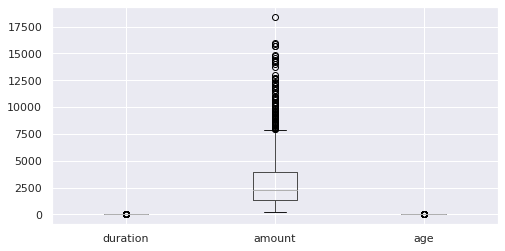

In [81]:
numeric_values=credit[numeric_features].copy()
numeric_values.boxplot()

4. Llevarás un entrenamiento usando validación cruzada entre los siguientes tres modelos de
aprendizaje automático: Regresión Logística, Árbol de Decisión y Bosque Aleatorio. Deberás
llevar a cabo el entrenamiento de los tres de manera conjunta usando un ciclo FOR. Recuerda
aplicar las transformaciones que definiste en tu Pipeline. El entrenamiento debe ser con las
siguientes características:
  
  a. Usa los parámetros predeterminados de cada modelo.
  
  b. En cada iteración deben calcularse todas las siguientes métricas: accuracy, precision,
recall, f1-score y Gmean. Todas estas métricas deben ser funciones que tú mismo debes
definir (Es decir, no usar las funciones de dichas métricas que te proporciona scikit-learn.
Sin embargo, sí puedes usar la información regresada por el método confusion_matrix()
de scikit-learn para definir las métricas).
 
  c. Usar validación cruzada estratificada con 5 particiones y con 3 repeticiones.
 
  d. Imprimir el valor de todas estas métricas, tanto para los datos de entrenamiento, como
para los de validación. Así como los diagramas de caja y bigotes de los tres modelos con la
métrica “recall”. ¿Alguno de los modelos está subentrenado o sobreentrenado? Justifica tu
respuesta.
 
  e. En particular obtengamos algunas de las llamadas curvas de aprendizaje para algunos de
estos casos. En dada gráfico debes incluir tus comentarios sobre el modelo generado:
   
    i. Obtener las curvas de aprendizaje (learning_curve) en la cual se va incrementando el tamaño de la muestra para el modelo de regresión Logística con su hiperparámetros predeterminados. Utilizar al menos 20 puntos en la partición de los conjuntos de entrenamiento y la métrica “f1-score”, como evaluación del desempeño de dicha función “learning_curve()”.
   
    ii. Obtener las curvas de validación (validation_curve) en la cual se va incrementando la complejidad del hiperparámetro “max_depth” para el modelo de árbol de decisión con sus hiperparámetros predeterminados. Utilizar valores de máxima profundidad desde 1 hasta 20 y con la métrica “f1-score” para la evaluación del desempeño del modelo.
   
    iii. Obtener las curvas de aprendizaje (learning_curve) en la cual se va incrementando el tamaño de la muestra para el modelo de regresión bosque aleatorio (random forest) con su hiperparámetros predeterminados. Utilizar al menos 20 puntos en la partición de los conjuntos de entrenamiento y la métrica “recall”, como evaluación del desempeño del modelo.

In [82]:
def mi_accuracy(yreal,ypred):
  VN,FP,FN,VP=confusion_matrix(yreal,ypred).flatten()
  accuracy=(VN+VP)/(VN+FP+FN+VP)
  return accuracy

def mi_precission(yreal,ypred):
  VN,FP,FN,VP=confusion_matrix(yreal,ypred).flatten()
  precision=(VP)/(VP+FP)
  return precision

def mi_recall(yreal,ypred):
  VN,FP,FN,VP=confusion_matrix(yreal,ypred).flatten()
  recall=(VP)/(VP+FN)
  return recall

def mi_f1score(yreal,ypred):
    VN,FP,FN,VP=confusion_matrix(yreal,ypred).flatten()
    recall=(VP)/(VP+FN)
    precision=(VP)/(VP+FP)
    f1score=(2*recall*precision)/(precision+recall)
    return f1score

def mi_gmean(yreal,ypred):
    VN,FP,FN,VP=confusion_matrix(yreal,ypred).flatten()
    recall=(VP)/(VP+FN)
    specifity=(VN)/(VN+FP)
    gmean=np.sqrt(recall*specifity)
    return gmean


In [83]:
def get_models():
  modelos = list()
  nombres = list()

  # LR - Regresión Logística:
  modelos.append(LogisticRegression())
  nombres.append('LR')

  # DT - Árbol de Decisión:
  modelos.append(DecisionTreeClassifier())
  nombres.append('DT')

  # RF . Bosque Aleatorio
  modelos.append(RandomForestClassifier())
  nombres.append('RF')

  return modelos, nombres


In [84]:
modelos, nombres = get_models()  # cargamos los modelos a comparar
resultadosLDR = list()   

for i in range(len(modelos)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])
  mismetricas={"accuracy":make_scorer(mi_accuracy),"precission":make_scorer(mi_precission),"recall":make_scorer(mi_recall),"f1score":make_scorer(mi_f1score),"gmean":make_scorer(mi_gmean)}
  kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
  resultados = cross_validate(pipeline, X, y, scoring=mismetricas, cv=kfold, error_score="raise")
  resultadosLDR.append(resultados)  

  print('%s:\nmean Accuracy: %.3f (%.4f)\nmean Precission: %.3f (%.4f)\nmeanRecall: %.3f (%.4f)\nmean F1-Score: %.3f (%.4f)\nGmean: %.3f (%.4f)\n' % (nombres[i],
                                                                          np.mean(resultados['test_accuracy']),
                                                                          np.std(resultados['test_accuracy']), 
                                                                          np.mean(resultados['test_precission']),
                                                                          np.std(resultados['test_precission']),
                                                                          np.mean(resultados['test_recall']),
                                                                          np.std(resultados['test_recall']), 
                                                                          np.mean(resultados['test_f1score']),
                                                                          np.std(resultados['test_f1score']),                                                                           
                                                                          np.mean(resultados['test_gmean']),
                                                                          np.std(resultados['test_gmean']),                                                                            
                                                                          ))

LR:
mean Accuracy: 0.754 (0.0245)
mean Precission: 0.798 (0.0164)
meanRecall: 0.868 (0.0306)
mean F1-Score: 0.831 (0.0181)
Gmean: 0.649 (0.0339)

DT:
mean Accuracy: 0.677 (0.0314)
mean Precission: 0.770 (0.0187)
meanRecall: 0.769 (0.0381)
mean F1-Score: 0.769 (0.0258)
Gmean: 0.597 (0.0353)

RF:
mean Accuracy: 0.762 (0.0192)
mean Precission: 0.780 (0.0116)
meanRecall: 0.920 (0.0252)
mean F1-Score: 0.844 (0.0137)
Gmean: 0.602 (0.0304)



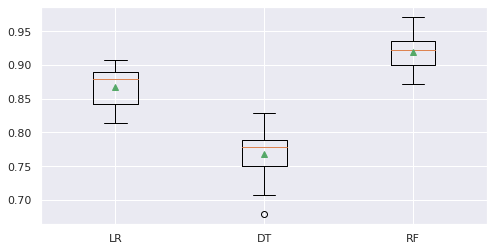

In [85]:
sns.set(rc={'figure.figsize':(8,4)})

bpRecall = list()
for i in range(len(resultadosLDR)):
  rr = resultadosLDR[i]['test_recall']
  bpRecall.append(rr)

plt.boxplot(bpRecall, labels=nombres, showmeans=True)
plt.show()

In [86]:
def mi_LearningCurvePlot(train_sizes, train_scores, val_scores):

    # Argumentos de entrada de la función mi_LearningCurvePlot:
    #      train_sizes : número de observaciones en el conjunto de entrenamiento.
    #      train_scores : Exactitud de cada partición en el proceso de Validación-Cruzada (VC) en los datos de entrenamiento.
    #                     La dimensión de este conjunto es (pxq) 
    #                                     donde p="número de particiones de manera incremental del conjunto de entrenamiento".
    #                                           q="número de particiones de VC" * "número de repeticiones de VC con RepitedStratifiedCV"
    #      val_scores : Exactitud de cada partición en el proceso de Validación-Cruzada en los datos de validación.
    #                   Es de la misma dimensión que los train_scores. 
    # Output: la salida es el gráfico con las curvas de aprendizaje.

    # Obtenemos los promedios y desviaciones estándar de cada renglón de los resultados de entrenamiento y validación
    # La dimensión de cada uno es p="número de particiones de manera incremental del conjunto de entrenamiento".
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Graficamos las curvas de aprendizaje incluyendo una región indicando la desviación estándar.
    plt.figure(figsize=(7,6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')
    
    plt.title('Curvas de Aprendizaje incrementando el tamaño de la muestra')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('F1-Score')
    plt.grid()
    plt.legend(loc='lower left')
    plt.show()

In [87]:
def mi_ModeloYCurvas(Xin):
       # Usemos primeramente el modelo de regresión logística
       # con sus parámetros predeterminados y semilla igual a 1.
       # Incremenetamos además el máximo de iteraciones para 
       # asegurar la convergencia de cada partición de la VC.

       modelo = LogisticRegression(max_iter=3000, random_state=1)

       ########################################################################
       # INICIA LA SECCIÓN PARA AGREGAR CÓDIGO.
       # Ejercicio 2
       # Sustituye "None" por el código que se te indica.

     
       # Ejercicio 2.1: Define el pipeline como se te indicó:
       # Se espera una línea de código.

       mi_pipe =  Pipeline(steps=[("ct", columnasTransformer), ("modelo", modelo)])


       # Ejercicio 2.2: Aplica validación cruzada estratificada y con repeticiones.
       #                Solo define los tres argumentos que se te indicaron.
       # Se espera una línea de código.

       mi_kfold = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=7)


       # Ejercicio 2.3: Genera un arreglo con los 40 valores de los tamaños de muestra:
       # Se espera una línea de código.
       
       delta_train_sz = np.linspace(0.1,1.0,40)


       # Ejercicio 2.4:: Incluye los argumentos que se te indican a la 
       # función learning_curve. Solo sustituye "None" por el valor del
       # argumento adecuado en cada caso.

       tr_sizes, tr_scores, val_scores = learning_curve(estimator = mi_pipe ,    
                                                        X = Xin,
                                                        y = y_tv,
                                                        cv = 20 ,
                                                        train_sizes = delta_train_sz ,
                                                        scoring="f1",
                                                        random_state=11)
       
       # TERMINA LA SECCIÓN PARA AGREGAR CÓDIGO.
       ######################################################################


       # Obtenemos el gráfico con las curvas de aprendizaje:
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)


Curvas de aprendizaje del modelo lineal:


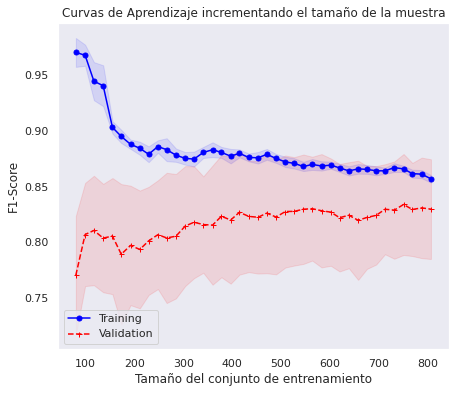

In [88]:
print('Curvas de aprendizaje del modelo lineal:')
mi_ModeloYCurvas(X_tv)

In [91]:
def mi_ValidationCurvePlot(train_sizes, train_scores, val_scores):

    # Argumentos de entrada de la función mi_LearningCurvePlot:
    #      train_sizes : número de observaciones en el conjunto de entrenamiento.
    #      train_scores : Exactitud de cada partición en el proceso de Validación-Cruzada (VC) en los datos de entrenamiento.
    #                     La dimensión de este conjunto es (pxq) 
    #                                     donde p="número de particiones de manera incremental del conjunto de entrenamiento".
    #                                           q="número de particiones de VC" * "número de repeticiones de VC con RepitedStratifiedCV"
    #      val_scores : Exactitud de cada partición en el proceso de Validación-Cruzada en los datos de validación.
    #                   Es de la misma dimensión que los train_scores. 
    # Output: la salida es el gráfico con las curvas de aprendizaje.

    # Obtenemos los promedios y desviaciones estándar de cada renglón de los resultados de entrenamiento y validación
    # La dimensión de cada uno es p="número de particiones de manera incremental del conjunto de entrenamiento".
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Graficamos las curvas de aprendizaje incluyendo una región indicando la desviación estándar.
    plt.figure(figsize=(7,6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')
    
    plt.title('Curvas de Aprendizaje incrementando el tamaño de la muestra')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('F1-Score')
    plt.grid()
    plt.legend(loc='lower left')
    plt.show()

In [90]:
def mi_ModeloArbol(Xin):
       # Usemos primeramente el modelo de regresión logística
       # con sus parámetros predeterminados y semilla igual a 1.
       # Incremenetamos además el máximo de iteraciones para 
       # asegurar la convergencia de cada partición de la VC.

       modelo = DecisionTreeClassifier(max_depth=20,random_state=0)

       ########################################################################
       # INICIA LA SECCIÓN PARA AGREGAR CÓDIGO.
       # Ejercicio 2
       # Sustituye "None" por el código que se te indica.

     
       # Ejercicio 2.1: Define el pipeline como se te indicó:
       # Se espera una línea de código.

       mi_pipe =  Pipeline(steps=[("ct", columnasTransformer), ("modelo", modelo)])


       # Ejercicio 2.2: Aplica validación cruzada estratificada y con repeticiones.
       #                Solo define los tres argumentos que se te indicaron.
       # Se espera una línea de código.

       mi_kfold = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=7)


       # Ejercicio 2.3: Genera un arreglo con los 40 valores de los tamaños de muestra:
       # Se espera una línea de código.
       
       delta_train_sz = np.linspace(0.1,1.0,40)


       # Ejercicio 2.4:: Incluye los argumentos que se te indican a la 
       # función learning_curve. Solo sustituye "None" por el valor del
       # argumento adecuado en cada caso.

       tr_sizes, tr_scores, val_scores = learning_curve(estimator = mi_pipe ,    
                                                        X = Xin,
                                                        y = y_tv,
                                                        cv = 20 ,
                                                        train_sizes = delta_train_sz ,
                                                        scoring="f1",
                                                        random_state=11)
       
       # TERMINA LA SECCIÓN PARA AGREGAR CÓDIGO.
       ######################################################################


       # Obtenemos el gráfico con las curvas de aprendizaje:
       mi_ValidationCurvePlot(tr_sizes, tr_scores, val_scores)

Curvas de validación del árbol de decisión:


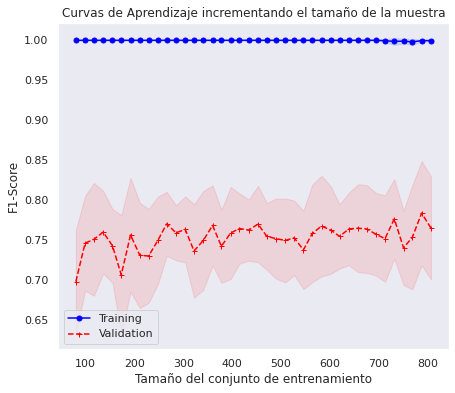

In [92]:
print('Curvas de validación del árbol de decisión:')
mi_ModeloArbol(X_tv)

In [93]:
def mi_ModeloRandomForest(Xin):
       # Usemos primeramente el modelo de regresión logística
       # con sus parámetros predeterminados y semilla igual a 1.
       # Incremenetamos además el máximo de iteraciones para 
       # asegurar la convergencia de cada partición de la VC.

       modelo = RandomForestClassifier()

       ########################################################################
       # INICIA LA SECCIÓN PARA AGREGAR CÓDIGO.
       # Ejercicio 2
       # Sustituye "None" por el código que se te indica.

     
       # Ejercicio 2.1: Define el pipeline como se te indicó:
       # Se espera una línea de código.

       mi_pipe =  Pipeline(steps=[("ct", columnasTransformer), ("modelo", modelo)])


       # Ejercicio 2.2: Aplica validación cruzada estratificada y con repeticiones.
       #                Solo define los tres argumentos que se te indicaron.
       # Se espera una línea de código.

       mi_kfold = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=7)


       # Ejercicio 2.3: Genera un arreglo con los 40 valores de los tamaños de muestra:
       # Se espera una línea de código.
       
       delta_train_sz = np.linspace(0.1,1.0,40)


       # Ejercicio 2.4:: Incluye los argumentos que se te indican a la 
       # función learning_curve. Solo sustituye "None" por el valor del
       # argumento adecuado en cada caso.

       tr_sizes, tr_scores, val_scores = learning_curve(estimator = mi_pipe ,    
                                                        X = Xin,
                                                        y = y_tv,
                                                        cv = 20 ,
                                                        train_sizes = delta_train_sz ,
                                                        scoring="f1",
                                                        random_state=11)
       
       # TERMINA LA SECCIÓN PARA AGREGAR CÓDIGO.
       ######################################################################


       # Obtenemos el gráfico con las curvas de aprendizaje:
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)

Curvas de validación del árbol de decisión:


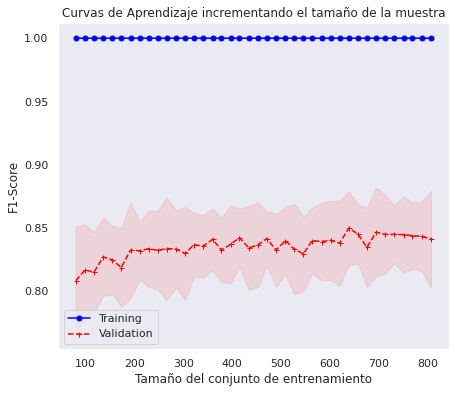

In [94]:
print('Curvas de validación del árbol de decisión:')
mi_ModeloRandomForest(X_tv)